In [44]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd

#astro
from astropy.cosmology import WMAP9 as cosmo
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const

# Graphic libraries

%matplotlib notebook
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(context='paper', fscale=1)
import seaborn as sns

#optional 3ML imports


from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')

from vapeplot import vapeplot
import pystan

In [47]:
vapeplot.set_palette('vaporwave')

In [12]:
def dNdz(z,r0,a, b):
    
    return r0 * np.power(z+1,a) * np.exp(-z/b)
    
    

In [13]:
def draw_zs(r0, alpha, beta):
    zs = np.linspace(0, 10, 1000)
    dndzs = dNdz(zs, r0, alpha, beta)
    ymax = np.max(dndzs)
    Nex = integrate.quad(dNdz,0.,10.,args=(r0,alpha, beta))[0]
    Ndraw = np.random.poisson(Nex)
    igen = 0
    while igen < Ndraw:
        y = np.random.uniform(low=0, high=ymax)
        z = np.random.uniform(low=0, high=10)
        if y < dNdz(z, r0, alpha, beta):
            igen += 1
            yield z

In [30]:
np.random.seed(123)

zsample = np.array([z for z in draw_zs(20., 2.,2.)])
noise_level = .2
z_measured = np.exp(np.log(zsample) + noise_level* np.random.normal(size=len(zsample)))


In [31]:
z_threshold = 6
selection = z_measured < z_threshold

<IPython.core.display.Javascript object>


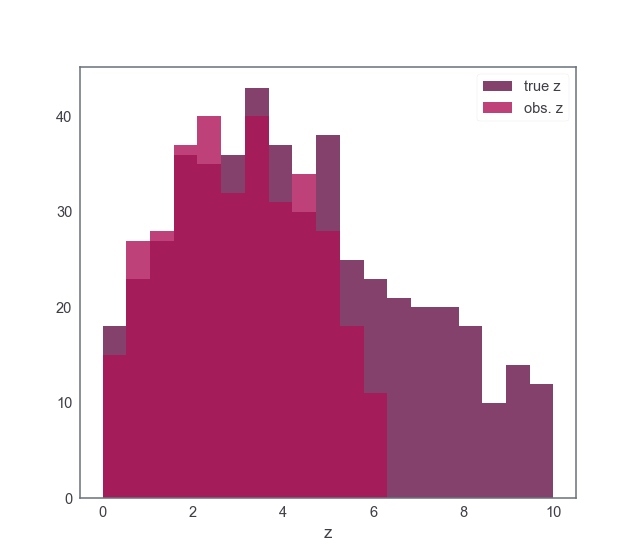

486 341


In [56]:
vapeplot.set_palette('sunset')
fig, ax = plt.subplots()


bins = np.linspace(0,10,20)
ax.hist(zsample,bins=bins,label='true z',histtype='stepfilled',alpha=.8)
ax.hist(z_measured[selection],bins=bins,label='obs. z',histtype='stepfilled',alpha=.8)

ax.set_xlabel('z')
ax.grid(False)

ax.legend()
print(len(z_measured), len(z_measured[selection]))
fig.savefig('/Users/jburgess/articles/vari_p/sample.pgf')

In [17]:
model = pystan.StanModel(file='marginal.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7dd26ba231714517affcd1fdb4ac699c NOW.


In [33]:
zmodel = np.linspace(0,10,500)


In [34]:
fit = model.sampling(
    data = {'nobs': len(z_measured[selection]), 
            'zobs': z_measured[selection],
            'Nnobs_max': 500,
            'sigma_obs': noise_level,
            'zth': z_threshold,
            'true_upper':10.,
            'meas_upper':15.,
            'zs_model': zmodel,
            'nmodel':500},
    iter = 6000,
    warmup=3000,
    thin = 2,
    seed=194838
)

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


<IPython.core.display.Javascript object>


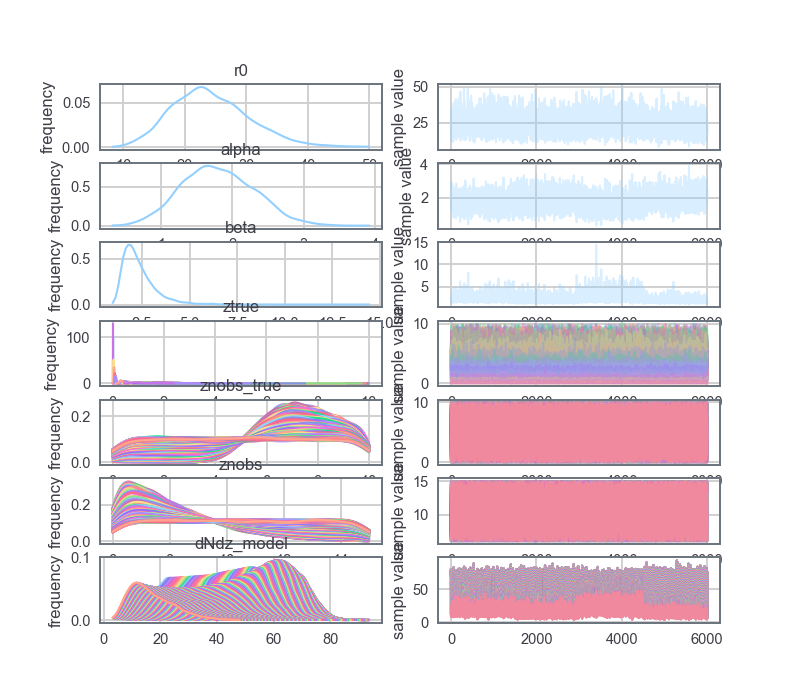

In [35]:
vapeplot.set_palette('vaporwave')
fit.plot();

In [36]:
chain_selected = fit.extract(permuted=True)

<IPython.core.display.Javascript object>


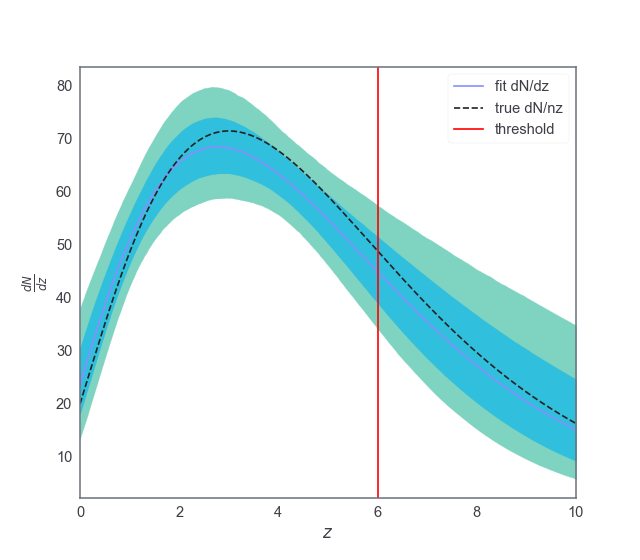

In [45]:
fig, ax = plt.subplots()
mallsoft = vapeplot.palette("mallsoft")



ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 97.5, axis=0), np.percentile(chain_selected['dNdz_model'], 2.5, axis=0), color=mallsoft[-1], alpha=1)
ax.fill_between(zmodel, np.percentile(chain_selected['dNdz_model'], 84, axis=0), np.percentile(chain_selected['dNdz_model'], 16, axis=0), color=mallsoft[-2], alpha=1)
ax.plot(zmodel, np.median(chain_selected['dNdz_model'], axis=0),color=mallsoft[-3],label='fit dN/dz')
ax.plot(zmodel, dNdz(zmodel, 20., 2., 2.), '--', color='k',label='true dN/nz')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\frac{dN}{dz}$')
ax.grid(False)

ax.axvline(6,color='red',label='threshold')
ax.set_xlim(0,10)
ax.legend()

fig.savefig('final.pgf')

/Users/jburgess/.environs/science3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jburgess/.environs/science3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jburgess/.environs/science3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


In [43]:
jtplot.style?